## Creating mock data for testing

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

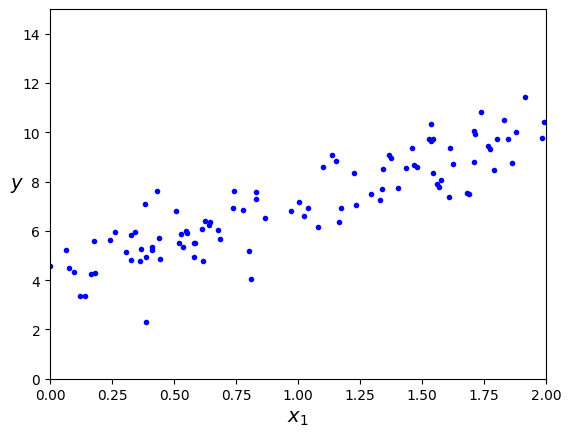

In [3]:
import matplotlib.pyplot as plt

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

## Computing the Parameters 

### Computing the Normal Equation

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.14869208],
       [2.98253181]])

### Making predictions

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.14869208],
       [10.11375569]])

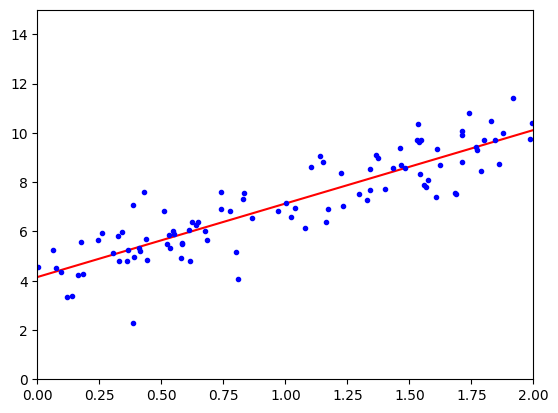

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

### Using Scikit-Learn

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.14869208]), array([[2.98253181]]))

In [9]:
lin_reg.predict(X_new)

array([[ 4.14869208],
       [10.11375569]])

### The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which you could call directly:

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.14869208],
       [2.98253181]])

### Pseudoinverse using Numpy

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.14869208],
       [2.98253181]])

## Gradient Descent

In [13]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.14869208],
       [2.98253181]])

### Stochastic Gradient Descent

In [14]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[4.16009907],
       [3.05461045]])

### Using Scikit-Learn

In [15]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21934579]), array([3.06614951]))

### Mini-batch Gradient Descent

In [16]:
n_iterations = 50
minibatch_size = 20

theta = np.random.randn(2,1)
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

t = 0

for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        
theta

array([[4.11412855],
       [2.93435712]])

## Polynomial Regression

### Generating some nonlinear data

In [17]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

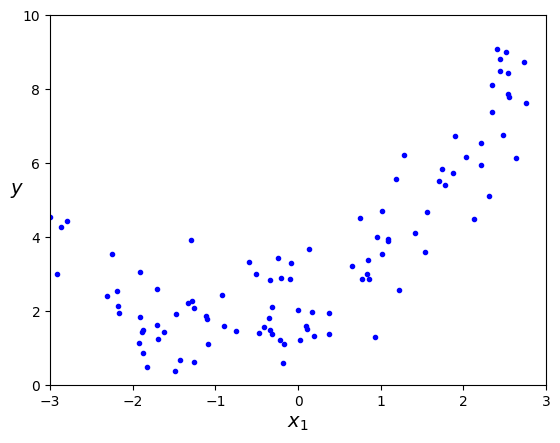

In [18]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

### Adding the square of each feature in the training set

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[1.0174529]
[1.0174529  1.03521041]


In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.08932466]), array([[0.96909845, 0.50856605]]))

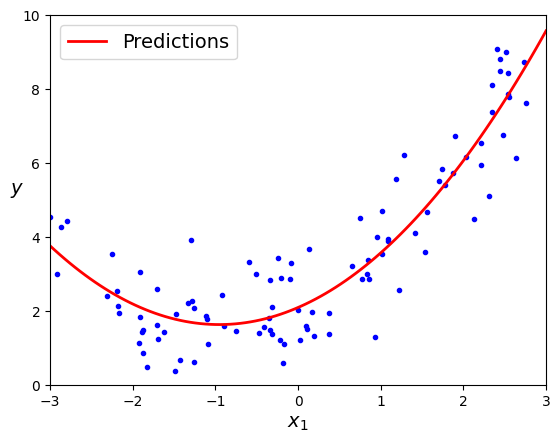

In [21]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning Curves

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

### Learning curves of a linear regression model

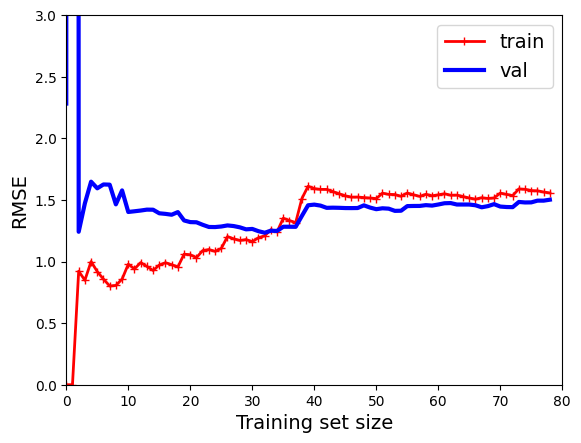

In [23]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

### Learning curves of a 10th-degree polynomial model

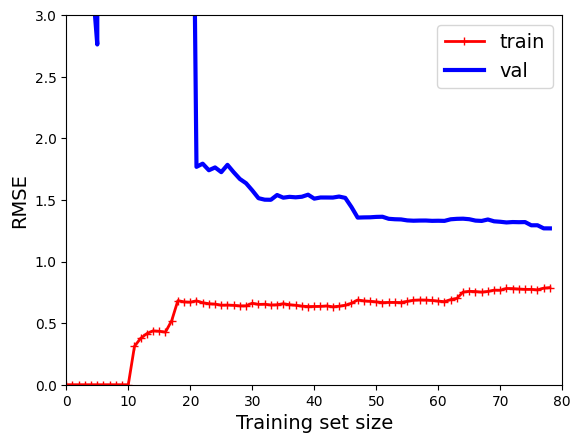

In [26]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

## Regularized Linear Models

### Ridge Regression    

In [27]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.99571018]])

In [29]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

C:\Users\Grzegorz\Desktop\um\linear_model_training\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([4.18026019])

### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso